<div>
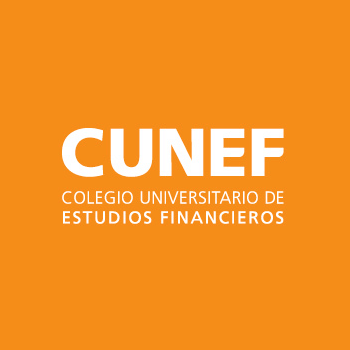
</div>

# **Matriculaciones en España (intervenido)**

En este notebook se mostrará la serie temporal **INTERVENIDA** de las **matriculaciones de vehículos en España** y observaremos cómo afectaría este conjunto de datos si suprimiéramos el momento COVID-19. 

Estructura del notebook:
    
    1) Librerías utilizadas
    2) Lectura y preprocesado de los datos
    3) Análisis exploratorio
    4) Elección del modelo predictivo
        4.1) Modelo de suavizado exponencial (ETS)
        4.2) Modelo autorregresivo integrado de media móvil (ARIMA)
        4.3) Modelo FB Prophet
    5) Predicción hasta finales de año 

## *1) Librerías utilizadas*

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import warnings
from prophet import Prophet
from sktime.forecasting.arima import AutoARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics import tsaplots
from sktime.utils.plotting import plot_correlations
from statsmodels.tsa.seasonal import seasonal_decompose
from sktime.transformations.series.boxcox import LogTransformer
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.performance_metrics.forecasting import MeanAbsolutePercentageError
from sktime.performance_metrics.forecasting import MeanSquaredError
from sktime.forecasting.exp_smoothing import ExponentialSmoothing
from sktime.transformations.series.difference import Differencer
from sktime.utils.plotting import plot_series
from sktime.forecasting.ets import AutoETS
warnings.filterwarnings('ignore')

Importing plotly failed. Interactive plots will not work.


## *2) Lectura del Excel y preparación de los datos*
Se procede a leer el archivo Excel de las matriculaciones de vehículos comerciales que han habido en España. 
- Fuente: https://datosmacro.expansion.com/negocios/matriculaciones-vehiculos/espana



In [3]:
df_matriculaciones = pd.read_excel("matriculaciones.xlsx", index_col=0)
df_matriculaciones = df_matriculaciones.iloc[:,0:3]
df_matriculaciones = df_matriculaciones.iloc[:,-1:]
df_matriculaciones

,Venta mensual vehículos
Fecha,
2014-01-01,62052
2014-02-01,78401
2014-03-01,90485
2014-04-01,92497
2014-05-01,94132
...,...
2022-03-01,71534
2022-04-01,80188
2022-05-01,97652


Vamos a representar gráficamente el conjunto de datos resaltando todo el momento COVID-19 y vamos a ver qué meses son los que más han alterado la predicción:

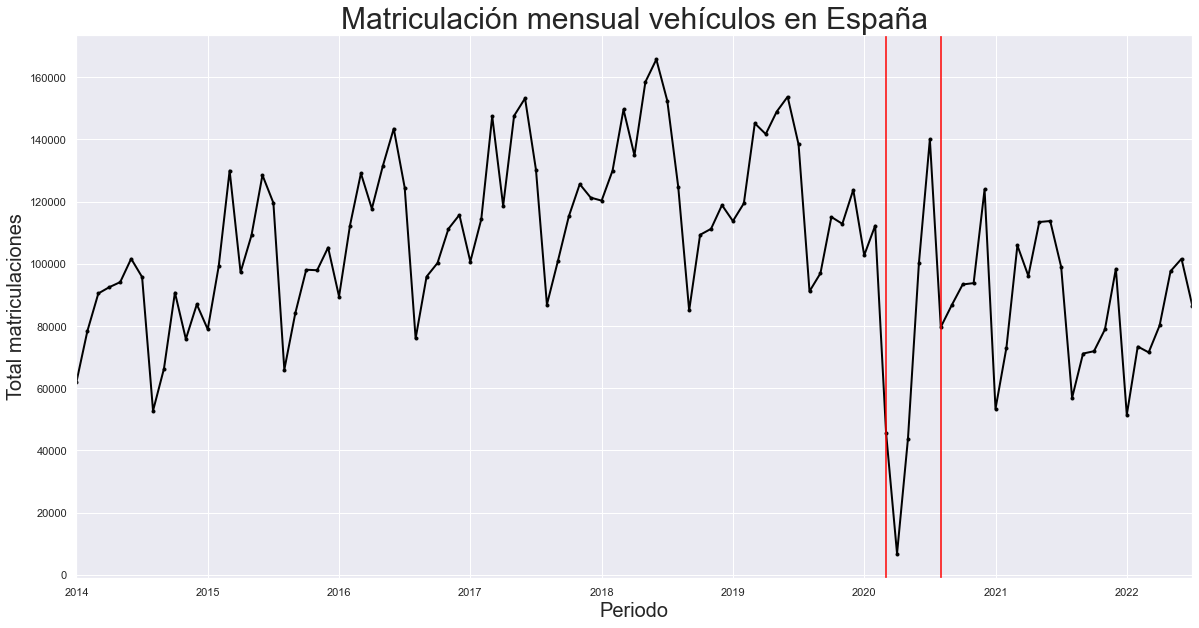

In [4]:
# Ploteamos nuestra serie temporal:
sns.set(rc={'figure.figsize':(20, 10)})
fig = df_matriculaciones['Venta mensual vehículos'].plot(marker='.', color = 'black', linewidth= 2)
fig.set_title('Matriculación mensual vehículos en España', fontsize = 30)
fig.set_ylabel('Total matriculaciones', fontsize = 20)
fig.axvline('2020-03-01', color = 'red', linewidth= 1.5)
fig.axvline('2020-08-01', color = 'red', linewidth= 1.5)
fig.set_xlabel('Periodo', fontsize = 20);

Vemos que desde marzo del 2020 hasta agosto del mismo son los meses que más desbalanceos hay por el efecto COVID-19, esto son **6 meses** (incluyendo ambos meses). Vamos a quedarnos con los datos hasta febrero del 2020, justo antes del inicio de la pandemia en nuestro país, y vamos a hacer un entrenamiento-test con autoETS para rellenar los datos hasta agosto 2020 inclusive. 

**¿Por qué con AutoETS?** Porque se ha comprobado en el análisis anterior que era más preciso que el autoARIMA.

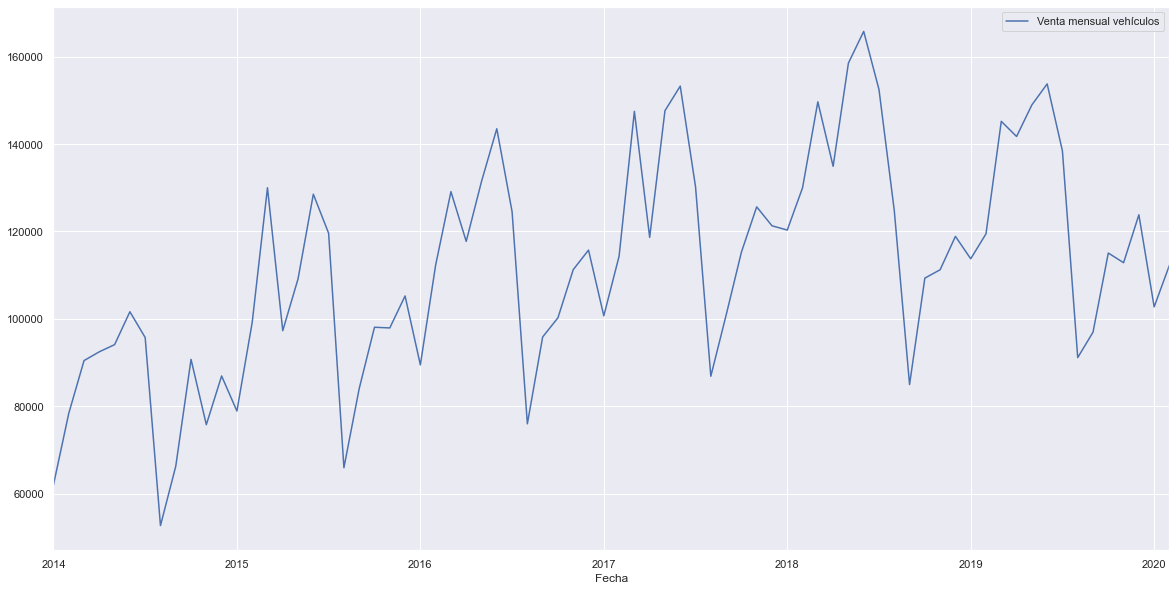

In [5]:
# Nos quedamos de momento con los datos hasta febrero de 2021:
df_matriculaciones2 = df_matriculaciones.loc['2013-02':'2020-02']
# Hacemos la predicción sobre esta time series:
df_matriculaciones2.plot();

Cantidad de períodos en Train: 68
Cantidad de períodos en Test: 6


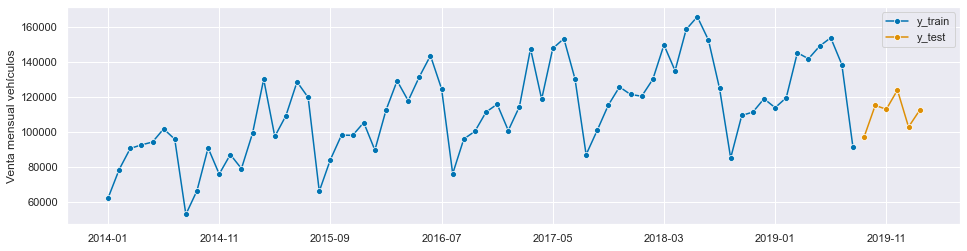

In [6]:
#y_train, y_test
y_train, y_test = temporal_train_test_split(
    y=df_matriculaciones2['Venta mensual vehículos'].astype('float64').to_period('M'),
    test_size = 6) #(mar2020 - ago2020)
plot_series(y_train, y_test, labels=["y_train","y_test"])
print('Cantidad de períodos en Train:', y_train.shape[0])
print('Cantidad de períodos en Test:', y_test.shape[0])
plt.show()

Aplicamos el modelo AutoETS para que testee el modelo entrenado.

In [8]:
fh = np.arange(1, y_test.shape[0]+1)
paro_auto_ets=AutoETS(auto=True,sp=12,n_jobs=1)

In [9]:
paro_auto_ets.fit(y_train)
matriculaciones_pred = paro_auto_ets.predict(fh)
matriculaciones_pred.round()

AutoETS(auto=True, n_jobs=1, sp=12)

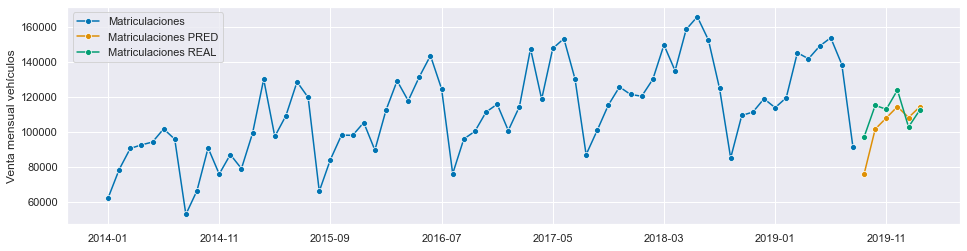

In [11]:
plot_series(y_train, matriculaciones_pred, y_test,
            labels=["Matriculaciones", 'Matriculaciones PRED', 'Matriculaciones REAL']);

El modelo se comporta bien y da una precisión buena, por lo que aplicaremos un horizonte nuevo de predicción y los datos que nos prediga hasta diciembre del 2021 serán los datos con los que vayamos a trabajar para testear los modelos y hacer una posterior predicción hasta finales del 2022.

In [12]:
matriculaciones_ficticio = df_matriculaciones.loc['2016-02': '2020-02']
fh=np.arange(1, 7)
df_auto = AutoETS(auto= True, 
                  sp =12, #mensual
                  n_jobs=1)
y = matriculaciones_ficticio['Venta mensual vehículos'].astype('float64').to_period('M')
df_auto.fit(y)
print(df_auto.summary())

                                    ETS Results                                    
Dep. Variable:     Venta mensual vehículos   No. Observations:                   49
Model:                            ETS(MNM)   Log Likelihood                -511.527
Date:                     Mon, 05 Sep 2022   AIC                           1055.055
Time:                             18:49:42   BIC                           1085.324
Sample:                         02-29-2016   HQIC                          1066.539
                              - 02-29-2020   Scale                            0.005
Covariance Type:                    approx                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
smoothing_level         0.2884      0.100      2.889      0.004       0.093       0.484
smoothing_seasonal   7.116e-05        nan        nan        nan 

In [13]:
#step 5: querying predictions
matriculaciones_pred = df_auto.predict(fh=list(fh))
matriculaciones_pred.round()

2020-03    140358.0
2020-04    125631.0
2020-05    143158.0
2020-06    150059.0
2020-07    132382.0
2020-08     93109.0
Freq: M, dtype: float64

Ya tenemos los datos predichos hasta diciembre-2021, vamos a suprimir los datos del desempleo alterados por la etapa COVID-19 y vamos a usar los datos predecidos por este modelo.

In [14]:
df_matriculaciones_new = df_matriculaciones
df_matriculaciones_new.loc['2020-03-01':'2020-08-01','Venta mensual vehículos'] = ['140358','125631',
                                                                                   '143158','150059',
                                                                                   '132382','93109']

Text(0.5, 0, 'Periodo')

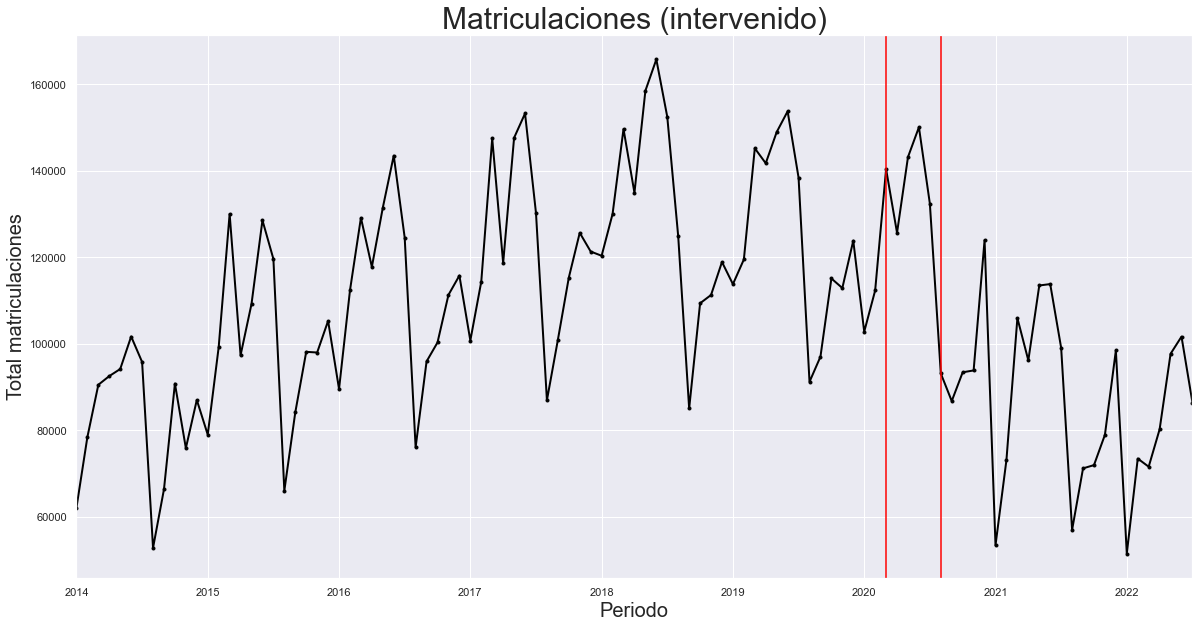

In [17]:
# hay que pasar los datos de tipo objeto a tipo numérico (float)
df_matriculaciones_new = pd.to_numeric(df_matriculaciones_new['Venta mensual vehículos'])
df_matriculaciones_new.dtypes

sns.set(rc={'figure.figsize':(20,10)})
fig=df_matriculaciones_new.plot(marker='.',color ='black',linewidth= 2)
fig.set_title('Matriculaciones (intervenido)',fontsize=30)
fig.set_ylabel('Total matriculaciones',fontsize=20)
fig.axvline('2020-03-01',color='red',linewidth=1.5)
fig.axvline('2020-08-01', color='red', linewidth=1.5)
fig.set_xlabel('Periodo',fontsize=20)
# fig.figure.savefig('../pics/df_paro_new/aftermanipulation');

Ahora sí que guarda una tendencia y una estacionalidad similar. Vamos a hacer un breve EDA (esta vez con todo el DataFrame al no haber momento atípico por COVID-19) y luego procedemos ahora a predecir la serie temporal con los modelos.

## *3) EDA*

### 3.1) Test de Dickey-Fuller aumentada

Esta prueba nos proporciona una verificación rápida y evidente de si la serie es estacionaria o no.

**La hipótesis nula (H0)** de la prueba es que la serie temporal se puede representar mediante una raíz unitaria, que no es estacionaria, es decir, que tiene alguna estructura dependiente del tiempo. 

**La hipótesis alternativa (H1)**, que rechaza la hipótesis nula, indica que la serie temporal es estacionaria.

Interpretamos este resultado utilizando el p-value. Un valor p por debajo del umbral de significancia (0.05) significa que la hipótesis nula se rechaza.

In [18]:
def test_stationarity(timeseries):
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

test_stationarity(df_matriculaciones_new)

Results of Dickey-Fuller Test:
Test Statistic                 -0.676311
p-value                         0.852790
#Lags Used                     13.000000
Number of Observations Used    89.000000
Critical Value (1%)            -3.506057
Critical Value (5%)            -2.894607
Critical Value (10%)           -2.584410
dtype: float64


**La serie temporal aquí no es estacionaria**, debido a que el p-value del test Dickey-Fuller (0.85) es mayor que 0.05, y eso indica que se acepta la hipótesis nula (H0).

### 3.2) Comportamiento mensual

Text(0.5, 1.0, 'Comportamiento mensual')

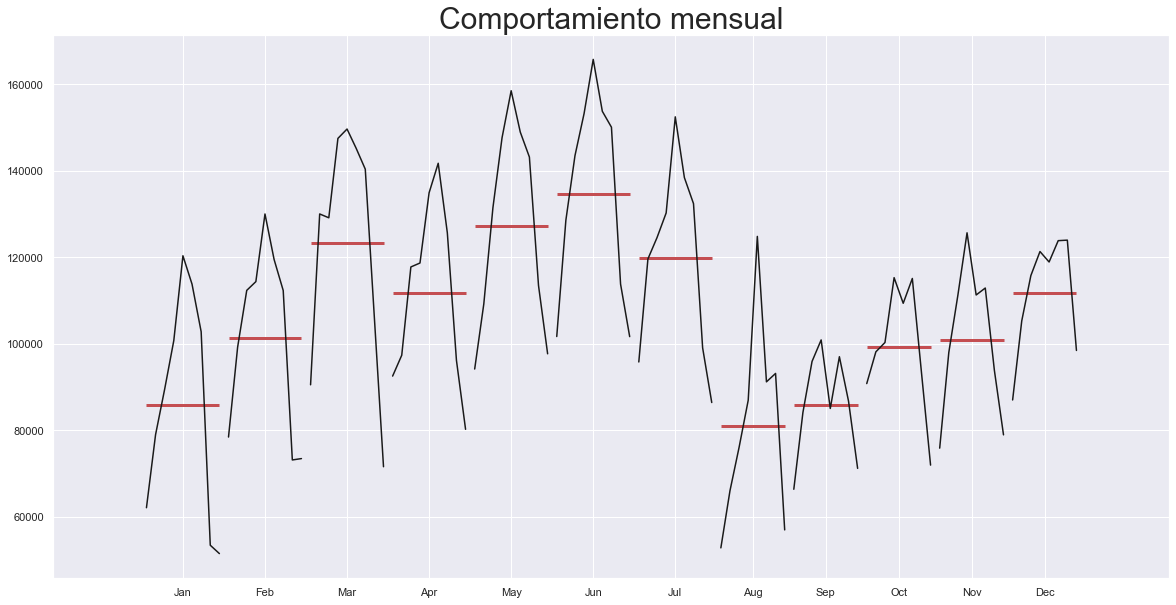

In [19]:
ax=plt.gca() 
sm.graphics.tsa.month_plot(df_matriculaciones_new,ax=ax)
ax.set_title('Comportamiento mensual',fontsize=30);
# fig.figure.savefig('../pics/df_paro_new/monthlybehavior.png');

Sigue cumpliendo con la estacionalidad del desempleo real.

### 3.3) Descomposición

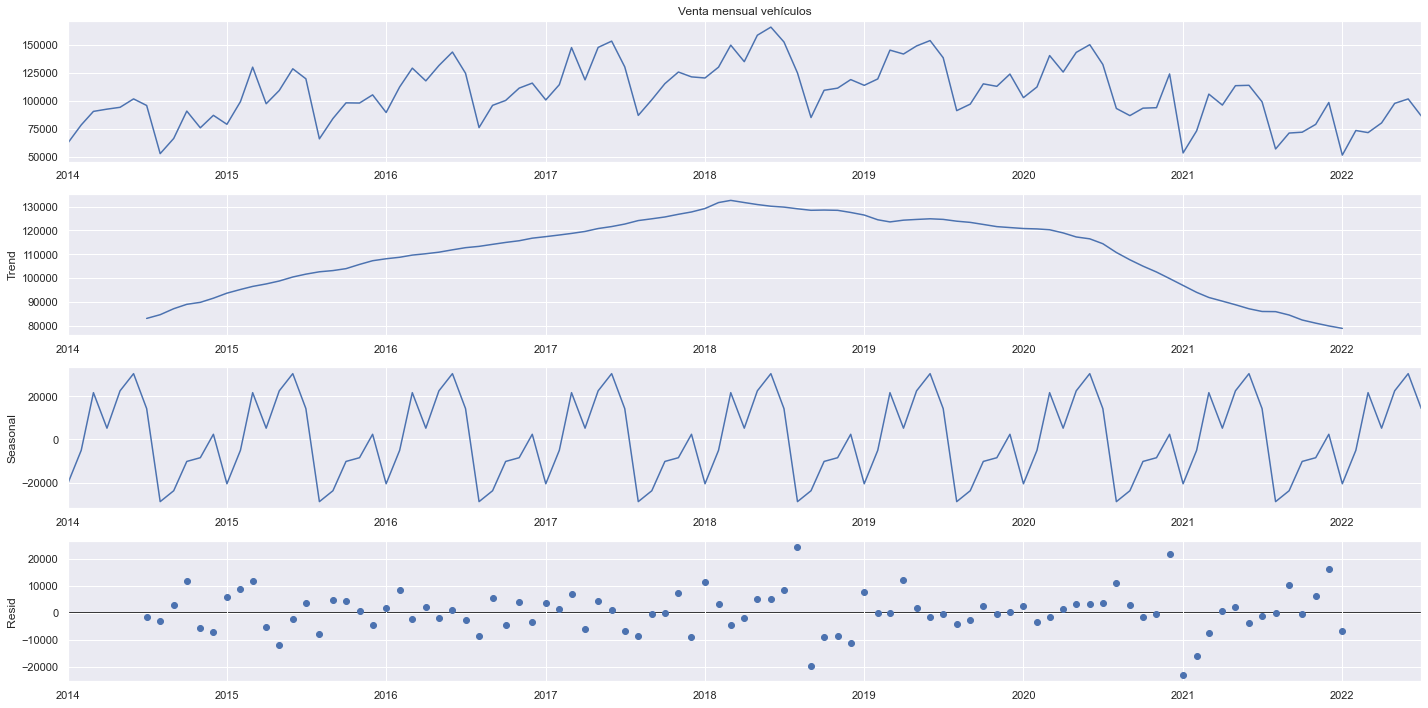

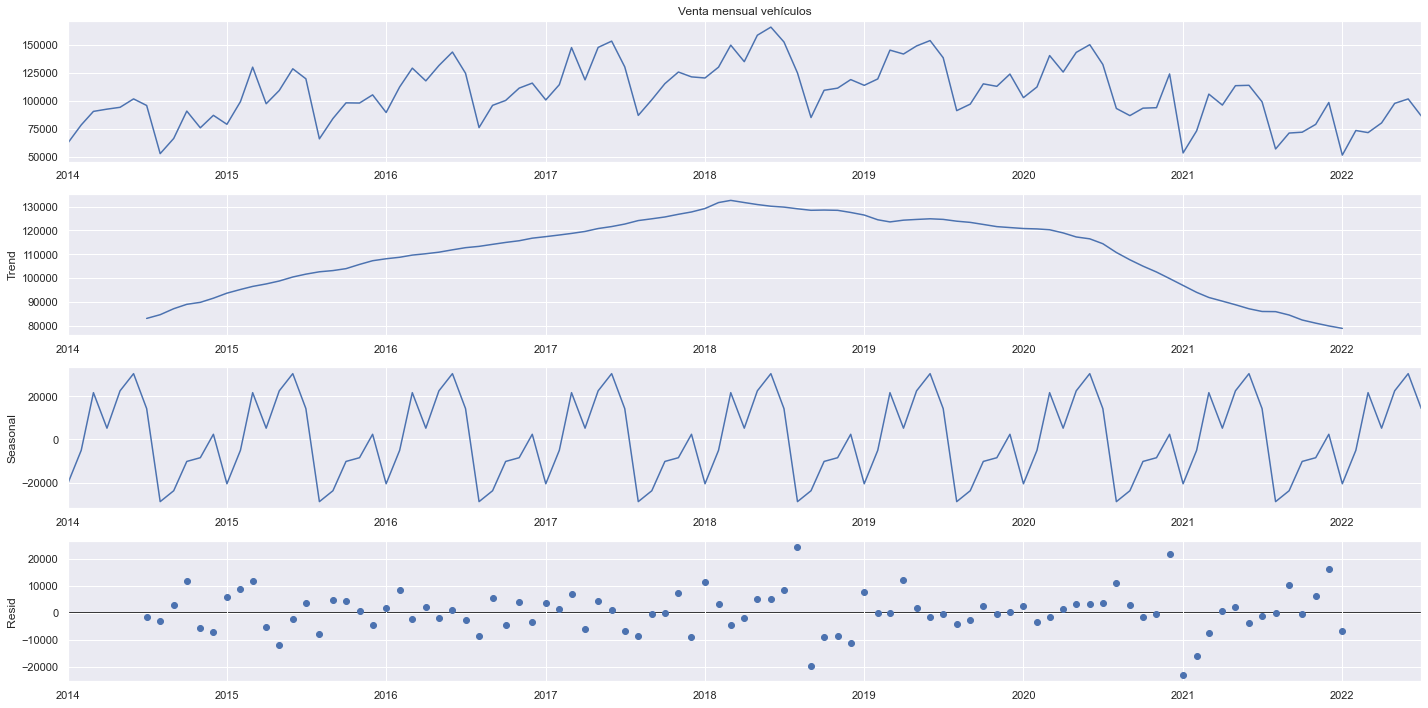

In [20]:
desglose=seasonal_decompose(df_matriculaciones_new, 
                                   model='additive', 
                                   period=12);
desglose.plot();
# plt.savefig('../pics/df_paro_new/decompose.png');

Analizando las gráficas una vez intervenida la serie, observamos:

- Que existe una **tendencia creciente hasta el 2018 y luego se vuelve decreciente**.
- Que la serie **no es estacionaria**.
- Hay **componente estacional**, similar a la serie temporal sin intervenir.


## *4) Estimación mediante modelos*



### 4.1) Modelo de Suavizado Exponencial (ETS)

Cantidad de períodos en Train: 74
Cantidad de períodos en Test: 29


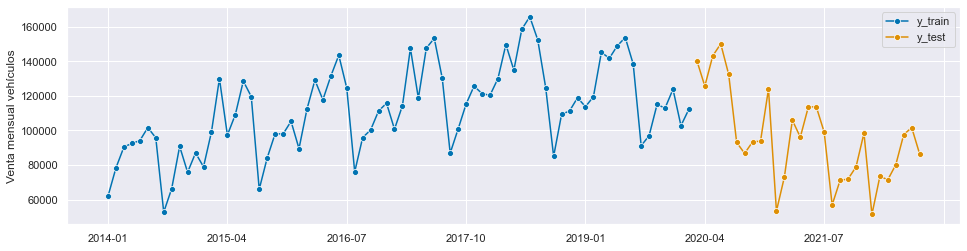

In [21]:
#Train-test
y_train,y_test_ets=temporal_train_test_split(
    y=df_matriculaciones_new.astype('float64').to_period('M').sort_index(),test_size=29
)
# Grafico para representar la separación de los datos
plot_series(y_train, y_test_ets, labels=["y_train","y_test"])
print('Cantidad de períodos en Train:', y_train.shape[0])
print('Cantidad de períodos en Test:', y_test_ets.shape[0])
plt.show()

In [23]:
# Especifico la cantidad de períodos a estimar para obtener las observaciones predichas en test.
fh = np.arange(1, y_test_ets.shape[0]+1)

# Selecciono el modelo y sus parámetros de predicción, al igual que los recursos a utilizar para entrenar
matriculacionesnew_auto_ets = AutoETS(auto=True, sp=12, n_jobs=-1)
matriculacionesnew_auto_ets.fit(y_train)
matriculacionesnew_auto_ets.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                    ETS Results                                    
===================================================================================
Dep. Variable:     Venta mensual vehículos   No. Observations:                   74
Model:                            ETS(MNM)   Log Likelihood                -780.023
Date:                     Mon, 05 Sep 2022   AIC                           1592.046
Time:                             18:49:50   BIC                           1628.911
Sample:                         01-31-2014   HQIC                          1606.752
                              - 02-29-2020   Scale                            0.007
Covariance Type:                    approx                                         
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
smoothing_level         0.3762      0.098      3.835      0.000       0.184       0.568
smoothing_seasonal   6.238e-05        nan        nan        nan         nan         nan
initial_level        8.177e+04        nan        nan        nan         nan         nan
initial_seasonal.0      1.1084        nan        nan        nan         nan         nan
initial_seasonal.1      1.0528        nan        nan        nan         nan         nan
initial_seasonal.2      1.0635        nan        nan        nan         nan         nan
initial_seasonal.3      0.9003        nan        nan        nan         nan         nan
initial_seasonal.4      0.8291        nan        nan        nan         nan         nan
initial_seasonal.5      1.2726        nan        nan        nan         nan         nan
initial_seasonal.6      1.4212        nan        nan        nan         nan         nan
initial_seasonal.7      1.3309        nan        nan        nan         nan         nan
initial_seasonal.8      1.2013        nan        nan        nan         nan         nan
initial_seasonal.9      1.3631        nan        nan        nan         nan         nan
initial_seasonal.10     1.1210        nan        nan        nan         nan         nan
initial_seasonal.11     1.0000        nan        nan        nan         nan         nan
===================================================================================
Ljung-Box (Q):                       11.09   Jarque-Bera (JB):                19.47
Prob(Q):                              0.68   Prob(JB):                         0.00
Heteroskedasticity (H):               0.87   Skew:                            -0.19
Prob(H) (two-sided):                  0.72   Kurtosis:                         5.48
===================================================================================

Warnings:
[1] Covariance matrix calculated using numerical (complex-step) differentiation.
"""

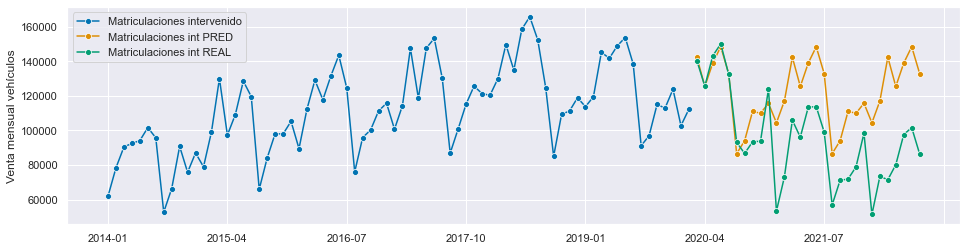

In [25]:
#Predicciones
matriculacionesnew_pred = matriculacionesnew_auto_ets.predict(fh=list(fh))

# Gráfica
plot_series(y_train, matriculacionesnew_pred, y_test_ets, labels=["Matriculaciones intervenido", 
                                                                  "Matriculaciones int PRED",
                                                                  "Matriculaciones int REAL"])
plt.show()

In [26]:
mse = MeanSquaredError(square_root=True)
mse_ets = mse(y_test_ets, matriculacionesnew_pred)
print('El modelo ETS genera un RMSE de:', round(mse_ets,2))

mape = MeanAbsolutePercentageError(symmetric=False)
mape_ets = mape(y_test_ets, matriculacionesnew_pred)
print('El modelo ETS genera un MAPE de: {}%'.format(round(mape_ets*100,2)))

El modelo ETS genera un RMSE de: 33468.22


El modelo sigue teniendo un error grande aunque bastante menos y predice mejor la serie temporal. 

### 4.2) Modelo ARIMA

Al tratarse de una serie no estacionaria hay que transformar la serie obtener mejores predicciones con el método de estimación ARIMA.

In [28]:
transformer = LogTransformer()
log_df_matriculaciones= transformer.fit_transform(df_matriculaciones_new)
log_df_matriculaciones.tail()

Fecha
2022-03-01    11.177928
2022-04-01    11.292129
2022-05-01    11.489165
2022-06-01    11.529035
2022-07-01    11.366546
dtype: float64

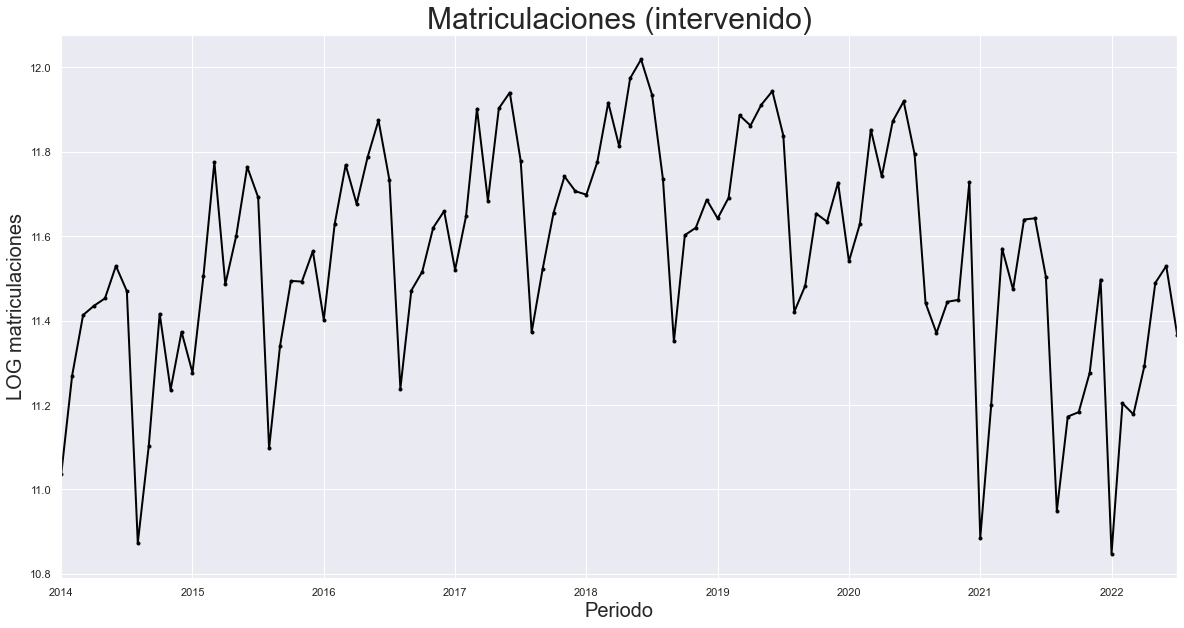

In [29]:
sns.set(rc={'figure.figsize':(20,10)})
fig=log_df_matriculaciones.plot(marker='.',color ='black',linewidth= 2)
fig.set_title('Matriculaciones (intervenido)',fontsize=30)
fig.set_ylabel('LOG matriculaciones',fontsize=20)
fig.set_xlabel('Periodo',fontsize=20);

Separamos el train y el test:

74 29


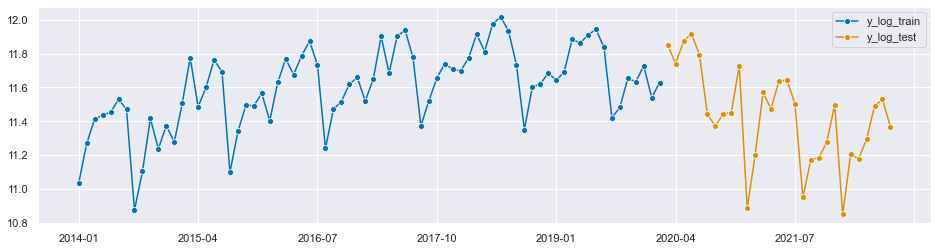

In [30]:
y_log_train,y_log_test=temporal_train_test_split(
    y=log_df_matriculaciones.astype('float64').to_period('M').sort_index(),test_size=29)
plot_series(y_log_train, y_log_test, labels=["y_log_train", "y_log_test"])
print(y_log_train.shape[0], y_log_test.shape[0])
plt.show()

Generamos el modelo y se entrena con los datos del train:

In [31]:
fh = np.arange(1, y_log_test.shape[0]+1)
matriculacionesnew_auto_arima=AutoARIMA(d=1,D=1,sp=12,suppress_warnings=True)

matriculacionesnew_auto_arima.fit(y_log_train)
matriculacionesnew_auto_arima.summary()

In [59]:
matriculacionesnew_pred_arima = matriculacionesnew_auto_arima.predict(fh)
np.exp(matriculacionesnew_pred_arima).round().tail()

2020-03    142351.0
2020-04    127557.0
2020-05    140971.0
2020-06    146947.0
2020-07    130674.0
Freq: M, dtype: float64

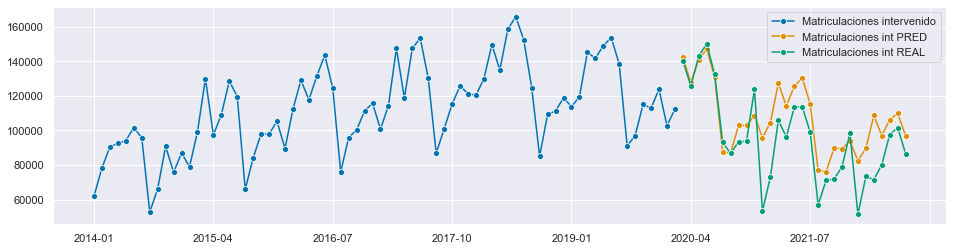

In [34]:
# representamos la serie predictiva
plot_series(np.exp(y_log_train), np.exp(matriculacionesnew_pred_arima), np.exp(y_log_test), 
            labels=["Matriculaciones intervenido", "Matriculaciones int PRED", "Matriculaciones int REAL"])
plt.show()

In [35]:
mse = MeanSquaredError(square_root=True)
mse_arima = mse(np.exp(y_log_test), np.exp(matriculacionesnew_pred_arima))
print('El modelo ARIMA genera un RMSE de:', round(mse_arima,2))

mape = MeanAbsolutePercentageError(symmetric=False)
mape_arima = mape(np.exp(y_log_test), np.exp(matriculacionesnew_pred_arima))
print('El modelo ARIMA genera un MAPE de: {}%'.format(round(mape_arima*100,2)))

El modelo ARIMA genera un RMSE de: 17356.08


Aquí el error del modelo de ARIMA es mucho mejor que el de ETS, se nota que la intervención ha mejorado la predicción de esta serie temporal intervenida.

### Comparativa gráfica entre los modelos ETS y ARIMA

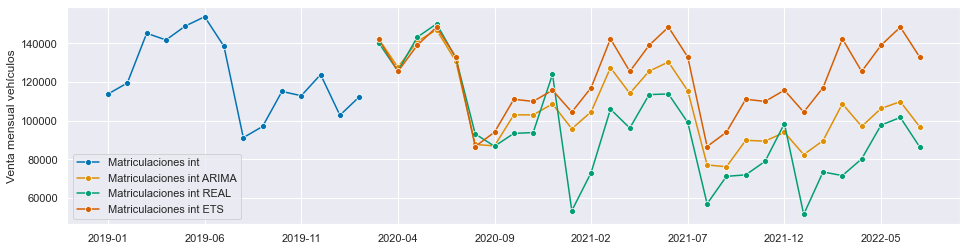

In [37]:
plot_series(y_train["2019":],np.exp(matriculacionesnew_pred_arima),np.exp(y_log_test),
            matriculacionesnew_pred,labels=['Matriculaciones int','Matriculaciones int ARIMA',
                                            'Matriculaciones int REAL','Matriculaciones int ETS'])
plt.show();
# plt.savefig('../pics/df_paro_new/etsarima.png')

Se aprecia bastante bien que ambos modelos se ajustan mucho más a estos datos intervenidos.

In [38]:
print('El modelo ETS genera un RMSE de:', round(mse_ets,2))
print('El modelo ARIMA genera un RMSE de:', round(mse_arima,2))

print('El modelo ETS genera un MAPE de: {}%'.format(round(mape_ets*100,2)))
print('El modelo ARIMA genera un MAPE de {}%'.format(round(mape_arima*100,2)))

El modelo ETS genera un RMSE de: 33468.22
El modelo ARIMA genera un RMSE de: 17356.08


Aquí el mejor modelo es claramente **ARIMA**, que da menos error. Ahora probamos con Prophet.

### 4.3) Prophet

FB Prophet es un modelo muy extendido para la predicción de series temporales desarrollado por Facebook. El objetivo de este paquete es dar a los usuarios una herramienta potente y de fácil uso para predecir resultados de distintas series temporales. Este modelo alcanza sus mejores resultados con series estacionarias o series con una tendencia y estacionalidad marcadas, como es el caso del turismo en España. Suele ser peor cuando aumenta la aleatoria de la muestra. 

Dentro de nuestro DataFrame cambiamos el nombre de la columna temporal *'Periodo'* y la de la variable objetivo *'Total'* por *'ds'* e *'y'*, y también quitamos el Periodo como índice, pues todos estos cambios son necesarios para que el modelo funcione bien.

In [41]:
prophet_train = df_matriculaciones_new.reset_index() #cambiamos de índice
prophet_train.columns = ['ds', 'y'] #renombramos las columnas

prophet_y_train = y_train.copy()
prophet_y_train = prophet_y_train.rename_axis('index').reset_index()
prophet_y_train.columns = ['ds', 'y']
prophet_y_train['ds'] = prophet_y_train['ds'].dt.to_timestamp(freq = 'M')
len(prophet_y_train)

74

In [42]:
prophet_y_test = y_test.copy()
prophet_y_test = prophet_y_test.rename_axis('index').reset_index()
prophet_y_test.columns = ['ds', 'y']
prophet_y_test['ds'] = prophet_y_test['ds'].dt.to_timestamp(freq = 'M')
len(prophet_y_test)

6

In [45]:
m = Prophet()
m.fit(prophet_y_train)

m_pred = m.make_future_dataframe(periods=len(prophet_y_test), freq='M')
prophet_forecast = m.predict(m_pred)

plt.plot(list(prophet_y_test['y']), '.-')
plt.plot(list(prophet_forecast.loc[74:, 'yhat']), '.-', label='Predicition')
plt.show()
# plt.savefig('../pics/df_paro_new/prophet.png')

18:50:24 - cmdstanpy - INFO - Chain [1] start processing
18:50:25 - cmdstanpy - INFO - Chain [1] done processing


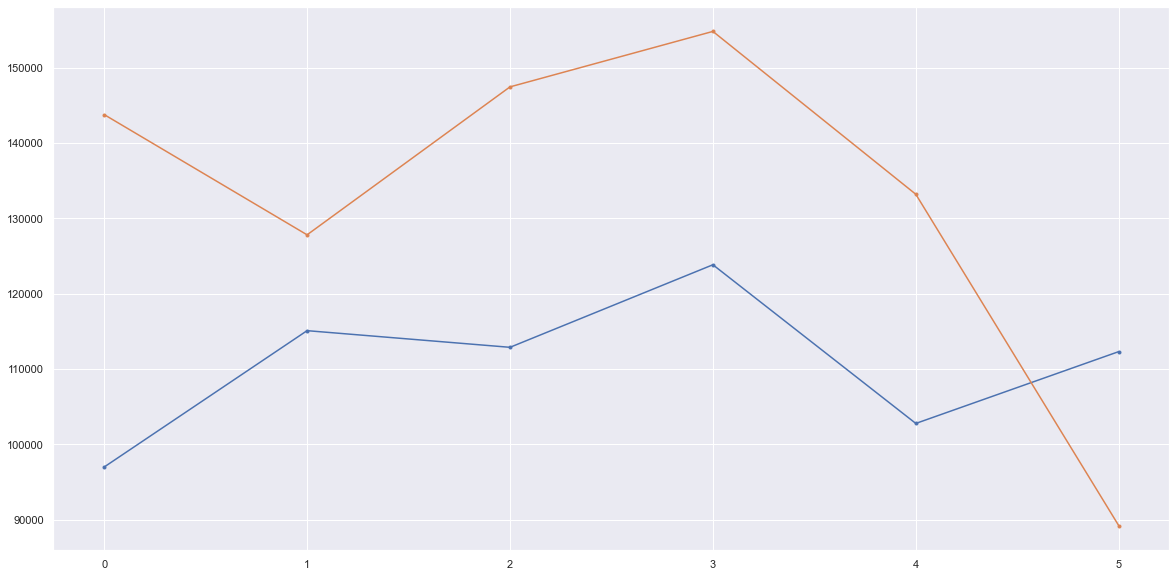

In [48]:
# Forecast Accuracy
# MAPE
mape = MeanAbsolutePercentageError(symmetric=False)
mape_prophet = mape(prophet_y_test['y'], prophet_forecast.loc[74:, 'yhat'])
print('El modelo Prophet genera un MAPE de: {}%'.format(round(mape_prophet*100,2)))

#Mean Squared Error
mse = MeanSquaredError(square_root=True)
mse_prophet = mse(prophet_y_test['y'],prophet_forecast.loc[74:, 'yhat'])
print('El modelo Prophet genera un RMSE de:', round(mse_prophet,2))

El modelo Prophet genera un MAPE de: 27.51%


In [49]:
# Forecast Accuracy


El modelo Prophet genera un RMSE de: 31521.36


In [50]:
prophet_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].round().tail()

,ds,yhat,yhat_lower,yhat_upper
75,2020-04-30,127793.0,119739.0,136508.0
76,2020-05-31,147429.0,139110.0,155247.0
77,2020-06-30,154791.0,146762.0,162962.0
78,2020-07-31,133177.0,125263.0,141447.0
79,2020-08-31,89205.0,80892.0,97693.0


### 4.4) Comparativa errores y elección del mejor modelo

Ahora comparamos entre las métricas de error que tenemos:
1) RMSE (Error dependiente de la escala)

In [51]:
print('El modelo ETS genera un RMSE de:', round(mse_ets,2))
print('El modelo ARIMA genera un RMSE de:', round(mse_arima,2))
print('El modelo Prophet genera un RMSE de:', round(mse_prophet,2))

El modelo ETS genera un RMSE de: 33468.22
El modelo ARIMA genera un RMSE de: 17356.08
El modelo Prophet genera un RMSE de: 31521.36


2) MAPE (Error porcentual)

In [52]:
print('El modelo ETS genera un MAPE de: {}%'.format(round(mape_ets*100,2)))
print('El modelo ARIMA genera un MAPE de {}%'.format(round(mape_arima*100,2)))
print('El modelo Prophet genera un MAPE de {}%'.format(round(mape_prophet*100,2)))

El modelo ETS genera un MAPE de: 35.42%
El modelo ARIMA genera un MAPE de 17.88%
El modelo Prophet genera un MAPE de 27.51%


Confirmamos que **el mejor modelo para la predicción de esta serie temporal es el ARIMA**, ya que es el que mejor se ajusta a los datos reales y es el que menor error da.

## *5) Predicción hasta finales de año*

A continuación realizamos la predicción de la serie temporal del desempleo intervenido hasta finales de año, es decir, hasta diciembre del 2022. 

In [58]:
# Especifico la cantidad de períodos a estimar para obtener las observaciones predichas en test.
fh = np.arange(1, 6)

# Selecciono el modelo y sus parámetros de predicción, al igual que los recursos a utilizar para entrenar
autoarima_predict = AutoARIMA(sp=12,suppress_warnings=True)
y = transformer.fit_transform(df_matriculaciones_new.astype('float64').to_period('M').sort_index())
autoarima_predict.fit(y)

# Resumen
autoarima_predict.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                                       y   No. Observations:                  103
Model:             SARIMAX(4, 0, 0)x(1, 0, [1, 2], 12)   Log Likelihood                  66.609
Date:                                 Mon, 05 Sep 2022   AIC                           -115.218
Time:                                         18:53:43   BIC                            -91.506
Sample:                                              0   HQIC                          -105.614
                                                 - 103                                         
Covariance Type:                                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0891      0.103      0.864      0.387      -0.113       0.291
ar.L1          0.2829      0.087      3.263      0.001       0.113       0.453
ar.L2          0.2209      0.128      1.732      0.083      -0.029       0.471
ar.L3          0.2438      0.161      1.515      0.130      -0.072       0.559
ar.L4          0.1112      0.167      0.664      0.507      -0.217       0.439
ar.S.L12       0.9438      0.042     22.261      0.000       0.861       1.027
ma.S.L12      -0.3078      0.141     -2.179      0.029      -0.585      -0.031
ma.S.L24       0.0262      0.245      0.107      0.915      -0.454       0.507
sigma2         0.0130      0.002      7.948      0.000       0.010       0.016
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):               271.83
Prob(Q):                              0.89   Prob(JB):                         0.00
Heteroskedasticity (H):               2.35   Skew:                            -1.92
Prob(H) (two-sided):                  0.01   Kurtosis:                         9.97
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [55]:
# Predicción del desempleo para los próximos 6 meses:
matriculacionesnew_pred = autoarima_predict.predict(fh=list(fh))
matriculacionesnew_pred = np.exp(matriculacionesnew_pred)
matriculacionesnew_pred

2022-08    56819.338207
2022-09    65345.231132
2022-10    67996.039425
2022-11    72801.480971
2022-12    90608.549688
Freq: M, dtype: float64

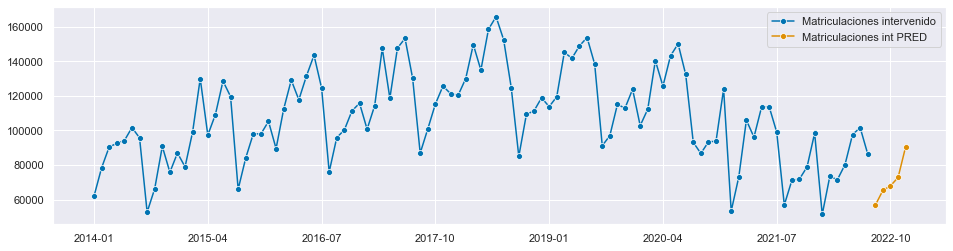

In [56]:
# Representamos gráficamente:
plot_series(np.exp(y), matriculacionesnew_pred, labels=["Matriculaciones intervenido", 
                                                        "Matriculaciones int PRED"])
plt.show()
# plt.savefig('../pics/df_paro_new/predict2022.png')

In [57]:
# Guardado a fichero CSV
matriculacionesnew_pred.to_csv('../predictions/matriculaciones_new.csv')